In [1]:
import numpy as np
import seaborn as sns
sns.set()
sns.set(font_scale=1.)
import matplotlib.pyplot as plt
from scipy.linalg import lstsq
from scipy.optimize import curve_fit, nnls
from itertools import product
from tqdm import tqdm
import matplotlib.pyplot as plt  # plotting library
from scipy.signal.windows import blackman
from scipy import fftpack
from quspin.tools.measurements import project_op
from tools import HubbardModel as fhmodel, InitializeArchive
import psutil
from multiprocessing import Pool
import pickle
import h5py

In [2]:
expectations = np.load('zerotrackingfive.npz')

"""show the expectations available here"""
print('expectations available: {}'.format(expectations.files))

"""example for using the analysis code"""
J_field = expectations['current']
J_field_track = expectations['tracking_current']
phi = expectations['phi']
tracking_phi = expectations['tracking_phi']

expectations available: ['H', 'neighbour', 'lhopup', 'lhopdown', 'nup0', 'ndown0', 'D0', 'nup1', 'ndown1', 'D1', 'nup2', 'ndown2', 'D2', 'nup3', 'ndown3', 'D3', 'nup4', 'ndown4', 'D4', 'nup5', 'ndown5', 'D5', 'nup6', 'ndown6', 'D6', 'nup7', 'ndown7', 'D7', 'nup8', 'ndown8', 'D8', 'nup9', 'ndown9', 'D9', 'current', 'phi', 'tracking_current', 'tracking_phi', 'tracking_neighbour']


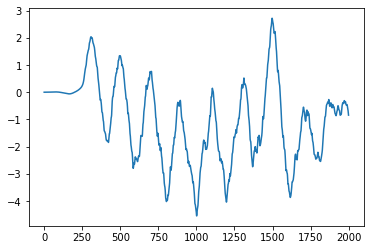

In [3]:
plt.plot(tracking_phi)
plt.show()

In [4]:
def Phi(t, f, s=0, phase=0):
    """
    Transform limited pulse 
    :param t: time
    :param f: frequency, aim for lower values
    :param s: time delay, must be positive
    :param phase: carrier wave phase delay, prefer to change s or t than phase
    :return: Transform limited pulse with enforcement of wave starting at 0
    """
    return np.sin(t - s) ** 2 * np.sin(f * (t - s) + phase) * (t > s) * (t < (s + np.pi)) 

t = np.linspace(0, np.pi, phi.size)

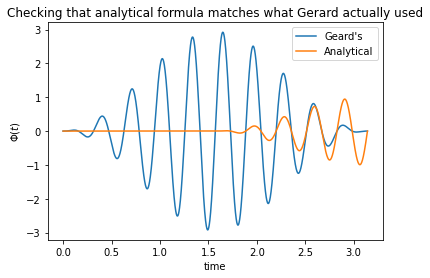

In [5]:
plt.title("Checking that analytical formula matches what Gerard actually used")
plt.plot(t, phi, label='Geard\'s')
plt.plot(t, Phi(t, 20, 0.5 * np.pi), label='Analytical')

plt.legend()
plt.ylabel('$\Phi(t)$')
plt.xlabel('time')
plt.show()

In [6]:
# number of pulses to use
n = 4

def superoscilating_pulse(t, *args):
    
    ampl = args[:n]
    phase = args[n:]
    freq = np.linspace(10, 20, n)
    
    return sum(a * Phi(t, f, s) for a, f, s in zip(ampl, phase, freq))
    

In [7]:
popt, pcov = curve_fit(
    superoscilating_pulse, 
    t, 
    tracking_phi,
    p0=np.random.rand(2 *n),
    max_nfev=10000,
    bounds=(
        np.append(np.zeros(n), t.min() * np.ones(n)),
        np.append(np.inf * np.ones(n), t.max() * np.ones(n)),
    )
)

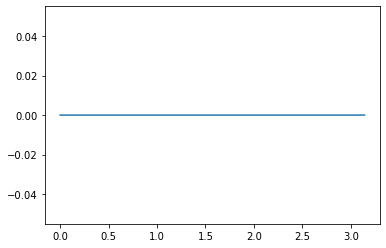

In [8]:
plt.plot(t, superoscilating_pulse(t, *popt))

In [64]:
n = 5

fields = np.array(
    [Phi(t, f, s) for f, s in product(np.linspace(0, 15, n), np.linspace(0, np.pi, 100 * n))]
).T

In [65]:
x = nnls(fields, tracking_phi)[0]

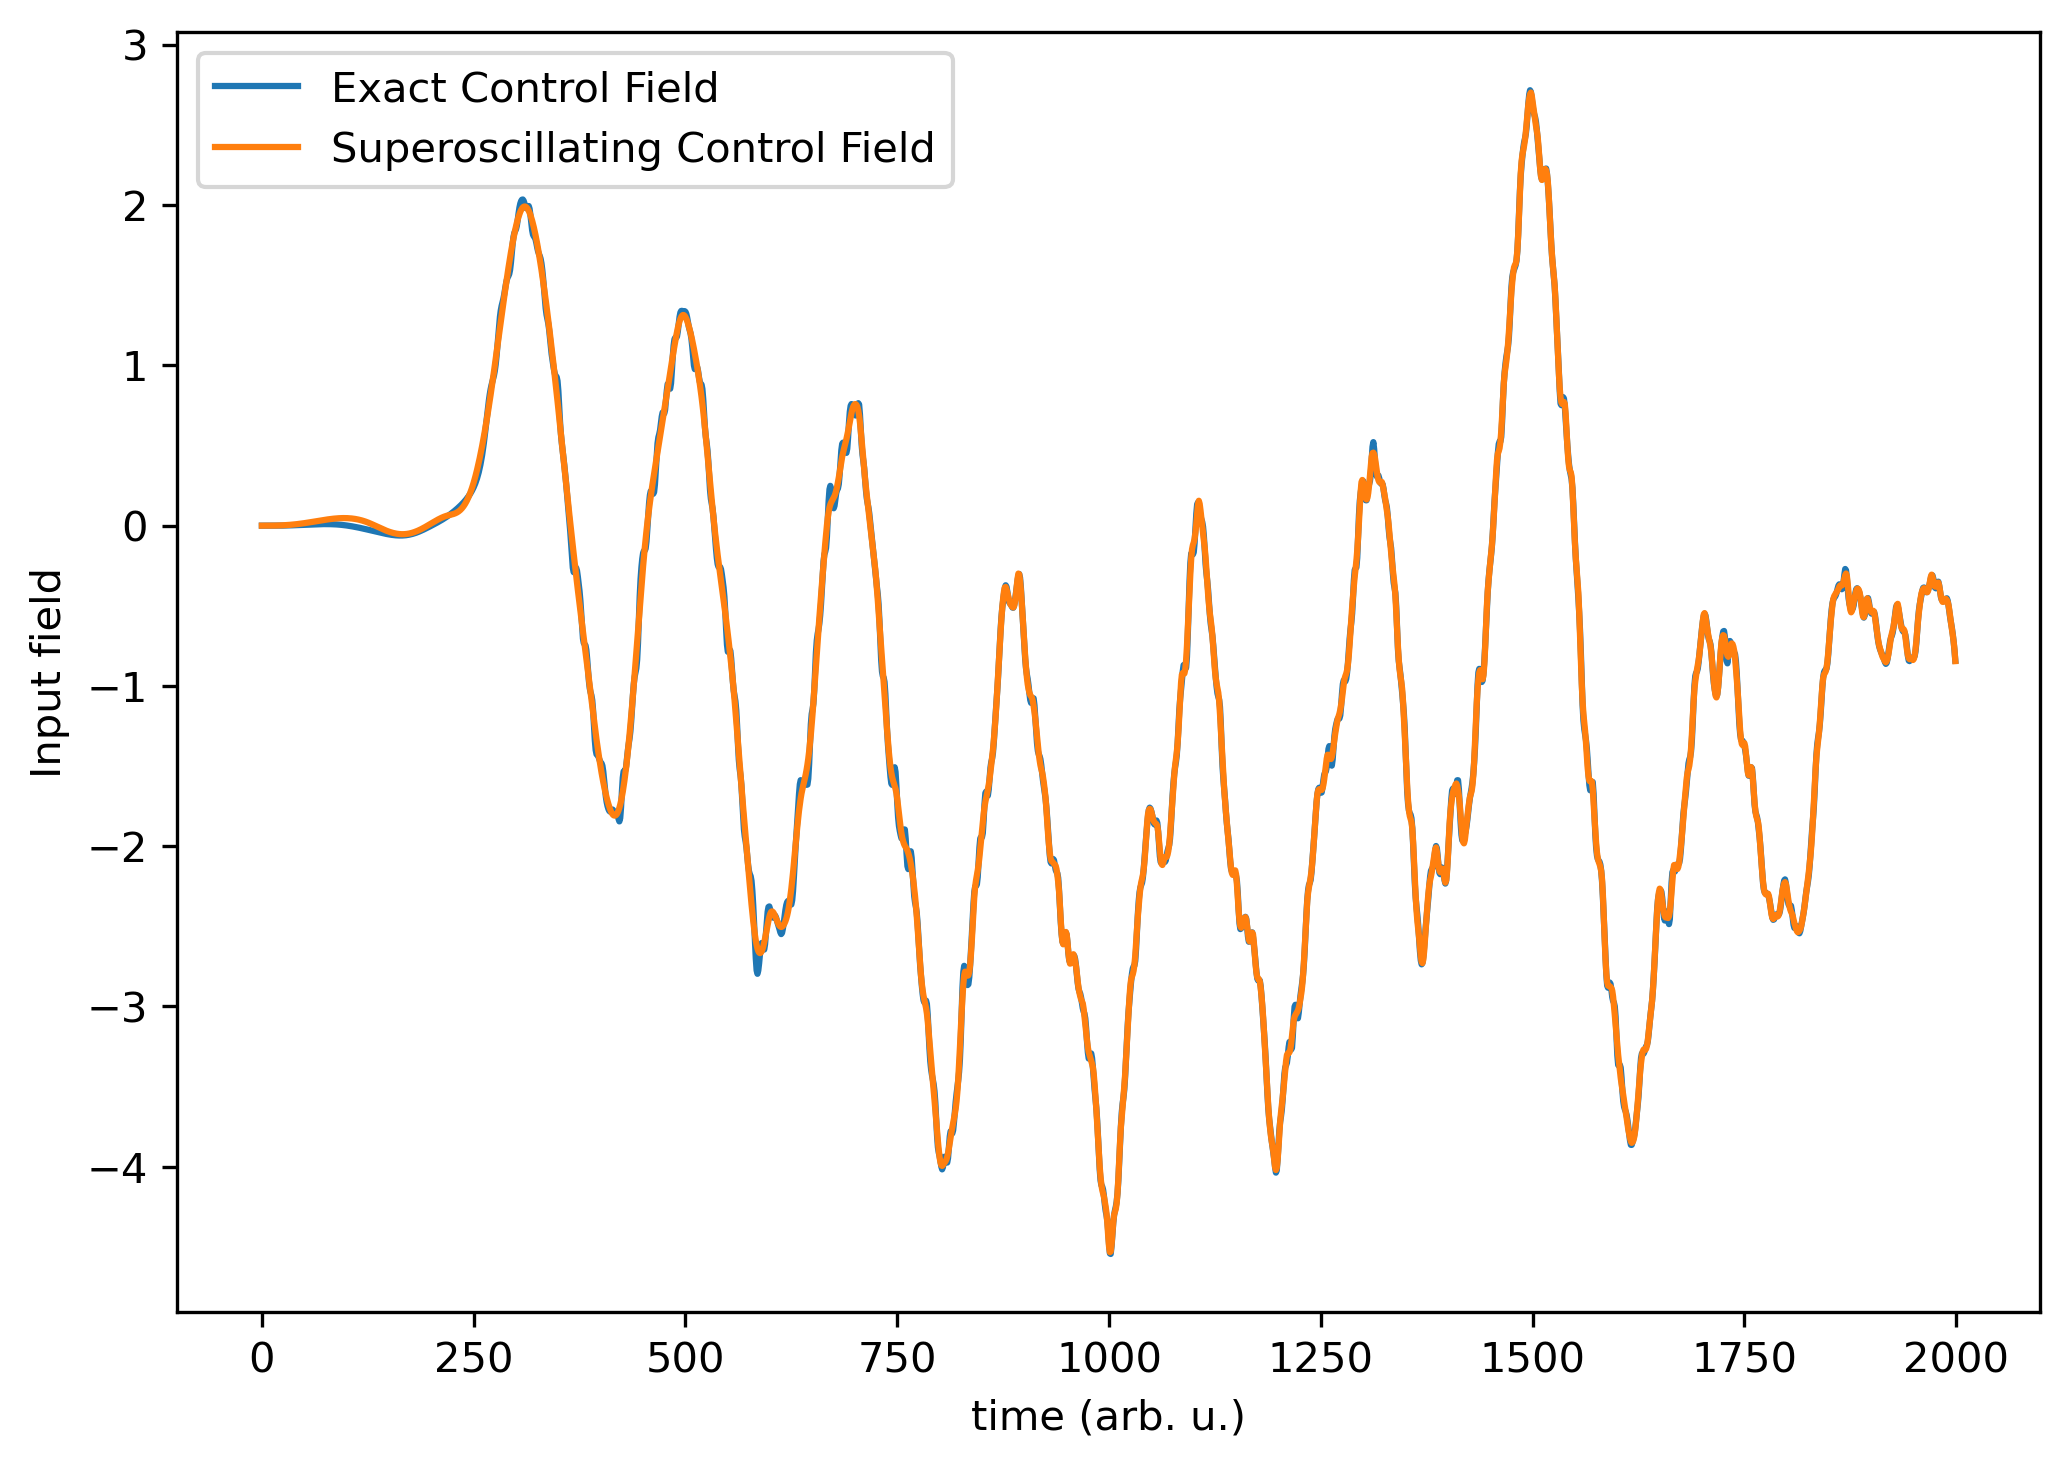

In [66]:
#plt.plot(phi, '--', color='k',label='Transform Limited Field')
plt.figure(figsize=(7, 5), dpi=300)
plt.plot(tracking_phi, label='Exact Control Field')
plt.plot(fields @ x, label='Superoscillating Control Field')

plt.legend()
plt.xlabel('time (arb. u.)')
plt.ylabel('Input field')
plt.tight_layout()
plt.savefig("./FieldComparrisonPlot.pdf")
plt.show()

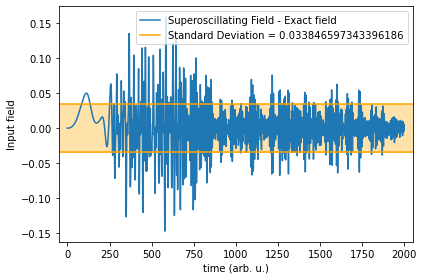

In [67]:
field_diff = (fields @ x)-tracking_phi
avg_diff = sum(field_diff) / len(field_diff)
std_dev_num = []
for n in range(0,len(field_diff)):
    std_dev_num.append((field_diff[n] + avg_diff) ** 2)
std_dev = np.sqrt(sum(std_dev_num)/len(field_diff))

plt.plot(field_diff, label='Superoscillating Field - Exact field')
plt.axhline(y=std_dev, linestyle='-', color='orange', label='Standard Deviation = ' + str(std_dev))
plt.axhline(y=-std_dev, linestyle='-', color='orange')
plt.fill_between([-50,len(field_diff)+50], -std_dev,std_dev,facecolor="orange",
            color='orange',
        alpha=0.333)

plt.legend()
plt.xlim(-50,len(field_diff)+50)
plt.xlabel('time (arb. u.)')
plt.ylabel('Input field')
plt.tight_layout()
plt.savefig("./DifferencePlot.pdf")
plt.show()

In [68]:
out = './BestFitSCF.npz'
BestFitSCF = fields @ x
np.savez(out, field=BestFitSCF)

(9,)


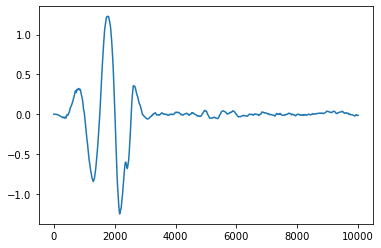

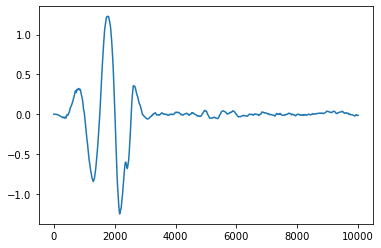

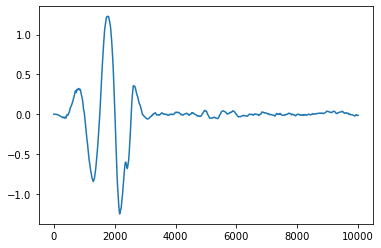

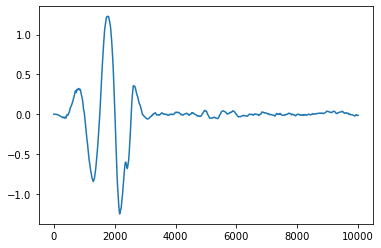

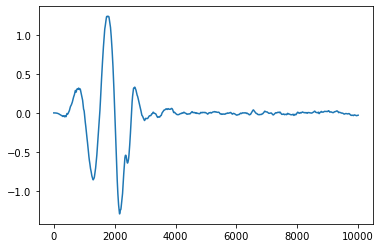

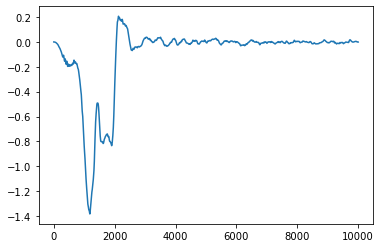

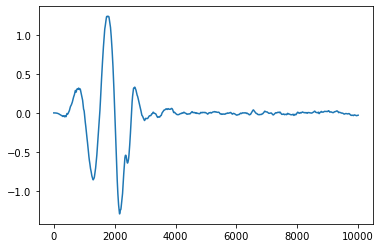

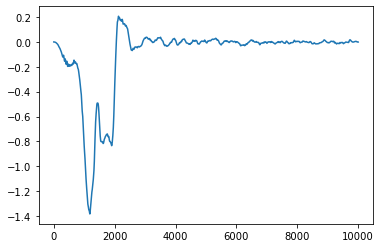

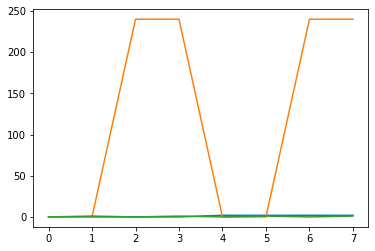

In [11]:
############################
#
# For plotting
#
############################

f = h5py.File('./Data/Looping/TESTLooping_8iterations-2,0maxamps-240,1maxdels-1,0maxfreqs-params_10sites-0,468U-0,52t0-10F0-4a-10cycles-10000steps.hdf5', 'r')
ls = list(f.keys())
print(np.array(ls).shape)
for _ in ls:
    plt.plot(np.array(f.get(_)[:]).real)
    plt.show()

In [2]:
field = 32.9  # field angular frequency THz
F0 = 10  # Field amplitude MV/cm
a = 4   # Lattice constant Angstroms

"""Parameters for a target or reference field"""
# Hubbard model
L = 10             # system size
N_up = L // 2 + L % 2   # number of fermions with spin up
N_down = L // 2     # number of fermions with spin down
N = N_up + N_down   # number of particles
t0 = 0.52       # hopping strength
U = 0.9 * t0    # interaction strength
pbc = True

# Parameters for evolving the system
cycles = 10     # time in cycles of field frequency
n_steps = 10000  # Number of steps for time resolution

# Bundle parameters to pass to Hubbard Model class for unit conversion
tgt_params = dict(
    nx=L,
    hopping=t0,
    interaction=U,
    n_up=N_up,
    n_down=N_down,
    angular_frequency=field,
    lattice_constant=a,
    field_amplitude=F0,
    chem_potential=0,
    cycles=cycles,
    n_steps=n_steps,
    ny=0,       # 1D simulations do not use y-axis
    soc=0,      # No spin orbit coupling
    gamma=0     #
)

# get the converted units for creating a target field
tgt = fhmodel(**tgt_params)

start = 0.0
stop = tgt.stop
times, dt = np.linspace(start, stop, num=n_steps, endpoint=True, retstep=True)

In [3]:
#file = "./Data/Looping/TESTLooping_1728iterations-2,0maxamps-240,1maxdels-1,0maxfreqs-params_10sites-0,468U-0,52t0-10F0-4a-10cycles-10000steps.hdf5"
file = './Data/Looping/Looping_CorrectedSweep.hdf5'
file2 = np.load('./Data/TargetsForTracking/TGTparams_10sites-0,416U-0,52t0-10F0-4a-10cycles-10000steps.npz')
file3 = np.load('./Data/TargetsForTracking/TGTparams_10sites-0,520U-0,52t0-10F0-4a-10cycles-10000steps.npz')
key = []
key.clear()
print(key)

file1 = dict() # {'comp_J': np.real(file2['current'])}

with h5py.File(file, 'r') as fin:
    ls = fin.keys()
    for _ in ls:
        if _ != 'master_params':
            key.append(_)
            file1[_]= np.real(fin[_][:])
#for _ in ls:
#    print("Run with params: {} finished".format(_))
    print(key)

diff=0
"""    diff = [
        [np.linalg.norm(J1[...] - J2[...]) for name1, J1 in fin.items() if name1 != 'params']
        for name2, J2 in fin.items() if name2 != 'params'
    ]"""



[]
['[0.5, 0.6283185307179586, 0.1]', '[0.5, 0.6283185307179586, 0.2]', '[0.5, 0.6283185307179586, 0.3]', '[0.5, 0.6283185307179586, 0.4]', '[0.5, 0.6283185307179586, 0.5]', '[0.5, 0.6283185307179586, 0.6]', '[0.5, 0.6283185307179586, 0.7]', '[0.5, 0.6283185307179586, 0.8]', '[0.5, 0.6283185307179586, 0.9]', '[0.5, 0.6283185307179586, 1.0]', '[0.5, 1.2566370614359172, 0.1]', '[0.5, 1.2566370614359172, 0.2]', '[0.5, 1.2566370614359172, 0.3]', '[0.5, 1.2566370614359172, 0.4]', '[0.5, 1.2566370614359172, 0.5]', '[0.5, 1.2566370614359172, 0.6]', '[0.5, 1.2566370614359172, 0.7]', '[0.5, 1.2566370614359172, 0.8]', '[0.5, 1.2566370614359172, 0.9]', '[0.5, 1.2566370614359172, 1.0]', '[0.5, 1.8849555921538759, 0.1]', '[0.5, 1.8849555921538759, 0.2]', '[0.5, 1.8849555921538759, 0.3]', '[0.5, 1.8849555921538759, 0.4]', '[0.5, 1.8849555921538759, 0.5]', '[0.5, 1.8849555921538759, 0.6]', '[0.5, 1.8849555921538759, 0.7]', '[0.5, 1.8849555921538759, 0.8]', '[0.5, 1.8849555921538759, 0.9]', '[0.5, 1.8

"    diff = [\n        [np.linalg.norm(J1[...] - J2[...]) for name1, J1 in fin.items() if name1 != 'params']\n        for name2, J2 in fin.items() if name2 != 'params'\n    ]"

In [5]:
# params is amps dels freqs in order
#data1.clear()
data1 = {'frequency': [], 'delay': [], 'amplitude': [], 'diff': [], 'current': []}

for i in key:
    params = [float(_) for _ in i[(i.find('[') + 1):i.find(']')].split(", ")]   # .replace(',', '.')
    diff1 = np.linalg.norm(file1[i] - np.real(file2['current']))
    data1['frequency'].append(params[2])
    data1['delay'].append(params[1])
    data1['amplitude'].append(params[0])
    data1['diff'].append(diff1)
    data1['current'].append(np.real(file1[i]))





"plt.plot(np.real(file2['current']))\nplt.plot(file1[key[20]])\nplt.show()"

In [21]:
print(np.unique(data1['amplitude']))
print(np.unique(data1['frequency']))
print(np.unique(data1['delay']))
print(np.shape(data1['current']))


[0.5  0.75 1.   1.25 1.5 ]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[0.62831853 1.25663706 1.88495559 2.51327412 3.14159265 3.76991118
 4.39822972 5.02654825 5.65486678]
(440, 10000)


In [8]:
pitimes = np.linspace(0, 2*np.pi, len(file2['current']))


In [190]:
print(data1['amplitude'])

[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,

(90,)
(90,)


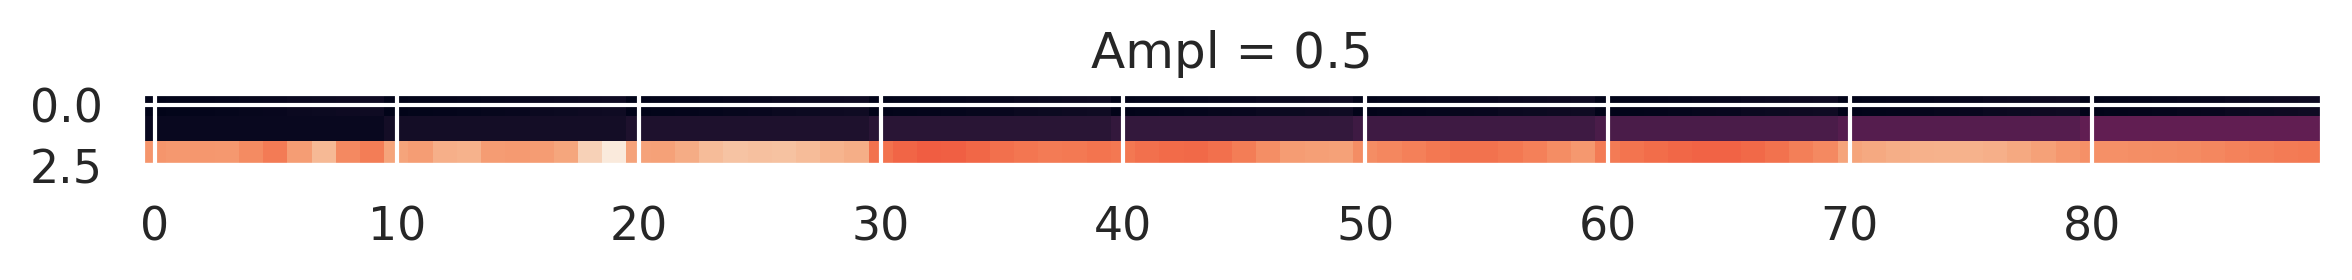

(90,)
(90,)


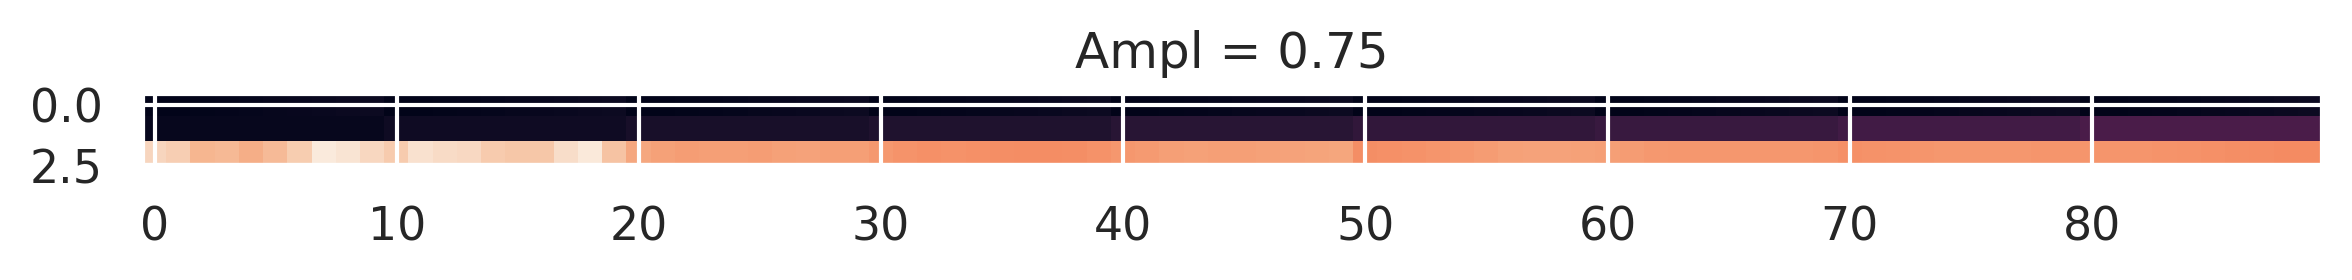

(90,)
(90,)


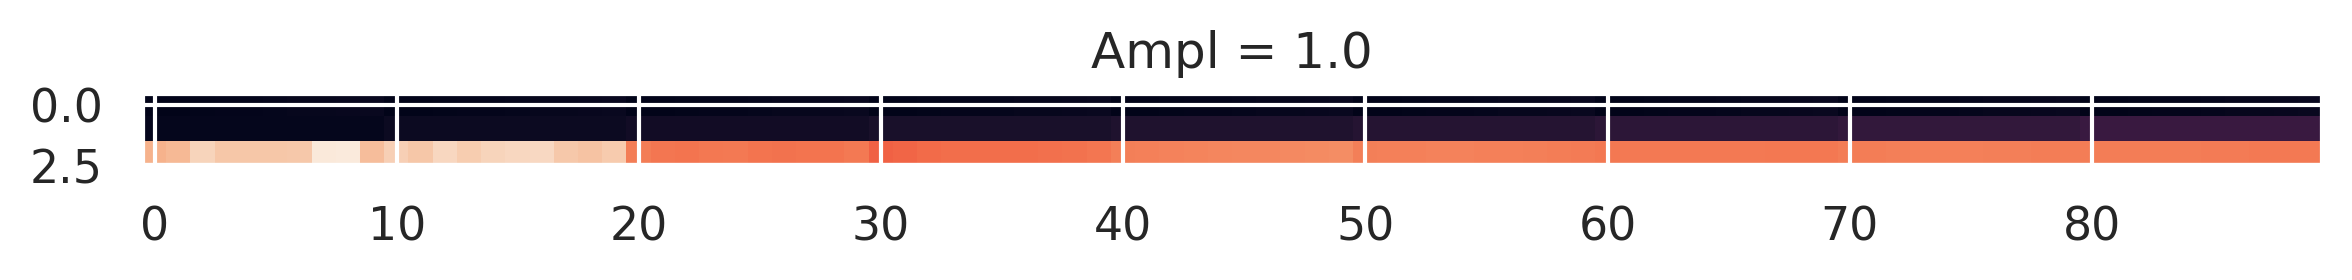

(90,)
(90,)


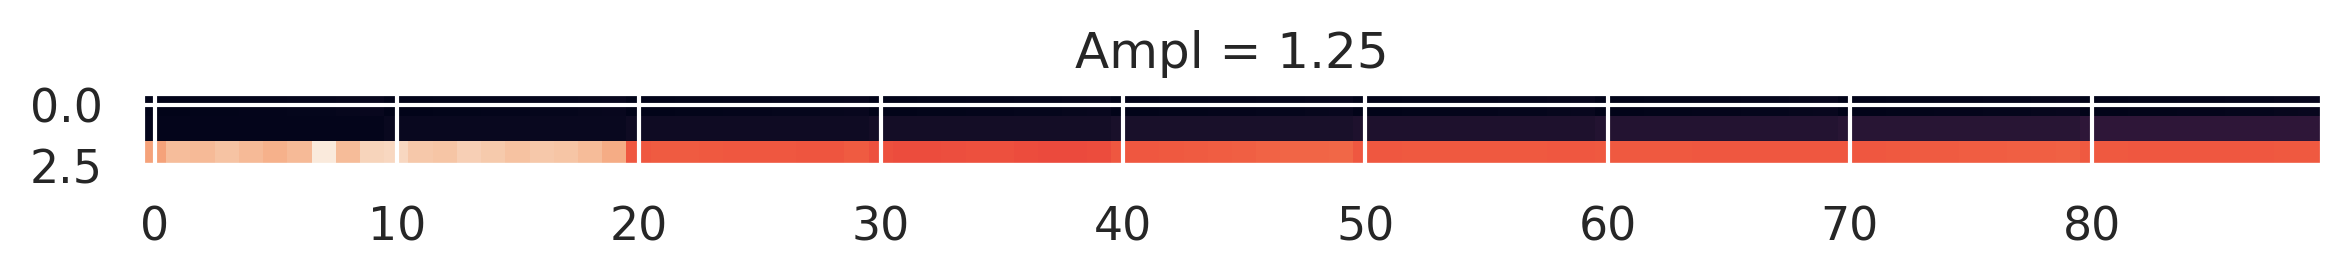

(80,)
(80,)


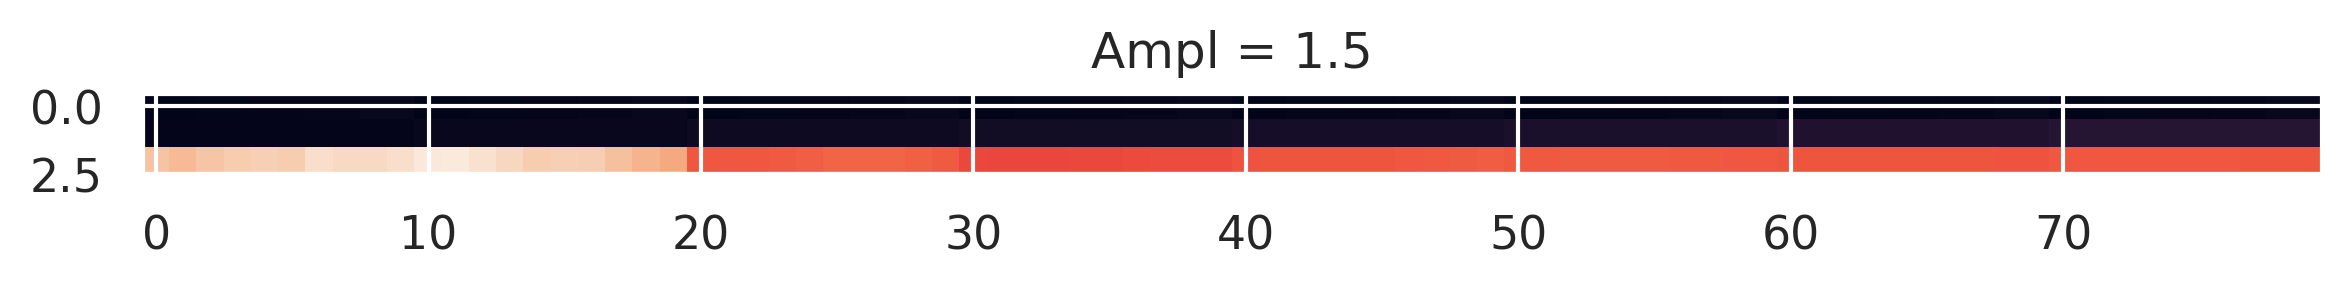

In [19]:
import pandas as pd

data2 = pd.DataFrame(data1)
fignum = 0


for ampl in data2.amplitude.unique():
    x = data2[data2.amplitude == ampl]['frequency']
    y = data2[data2.amplitude == ampl]['delay']
    z = data2[data2.amplitude == ampl]['diff']
    print(np.shape(z))
    print(np.shape(x))
    plt.figure(num=fignum, figsize=(8,6), dpi=300)
    fignum+=1
    plt.title(f"Ampl = {ampl}")
    #sns.scatterplot(data=data2[data2.amplitude == ampl], x='frequency', y='delay', size='diff', sizes=(5, 250), alpha=0.5)
    #plt.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0)
    plt.imshow((x, y, z))
    plt.tight_layout()
    #plt.savefig(f"./Plots/Looping/DiffPlot_Ampl={ampl}.pdf")
    plt.show()

1000


/tmp/ipykernel_83398/403660429.py:6: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


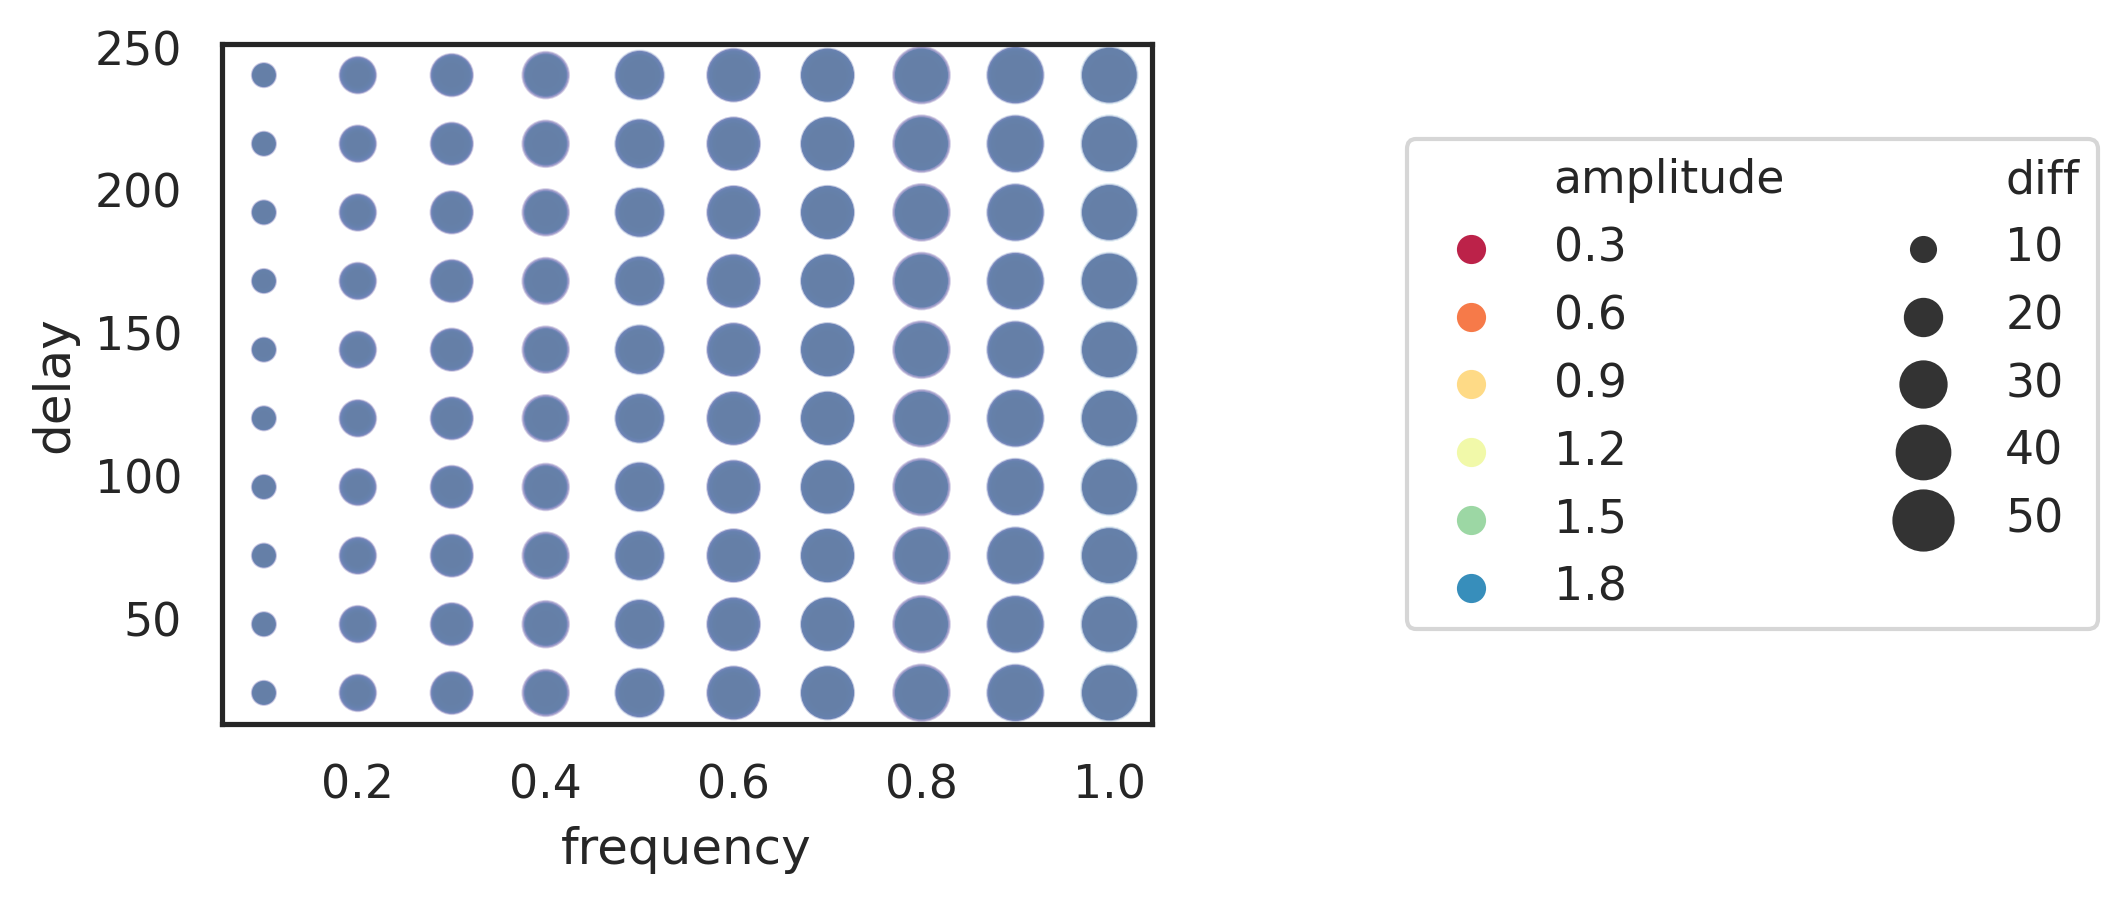

In [169]:


plt.figure(figsize=(4, 3), dpi=300)
sns.set(style="white")
print(len(data1['diff']))
sns.scatterplot(data=data1, x='frequency', y='delay', size='diff', sizes=(2, 200), hue='amplitude', palette="Spectral", hue_norm=None, alpha=0.5)
plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=2)
plt.tight_layout()
plt.savefig('./Plots/SweepInit.pdf')
plt.show()

/home/dustin/anaconda3/envs/Superoscillations/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


ValueError: x and y must have same first dimension, but have shapes (10000,) and (1,)

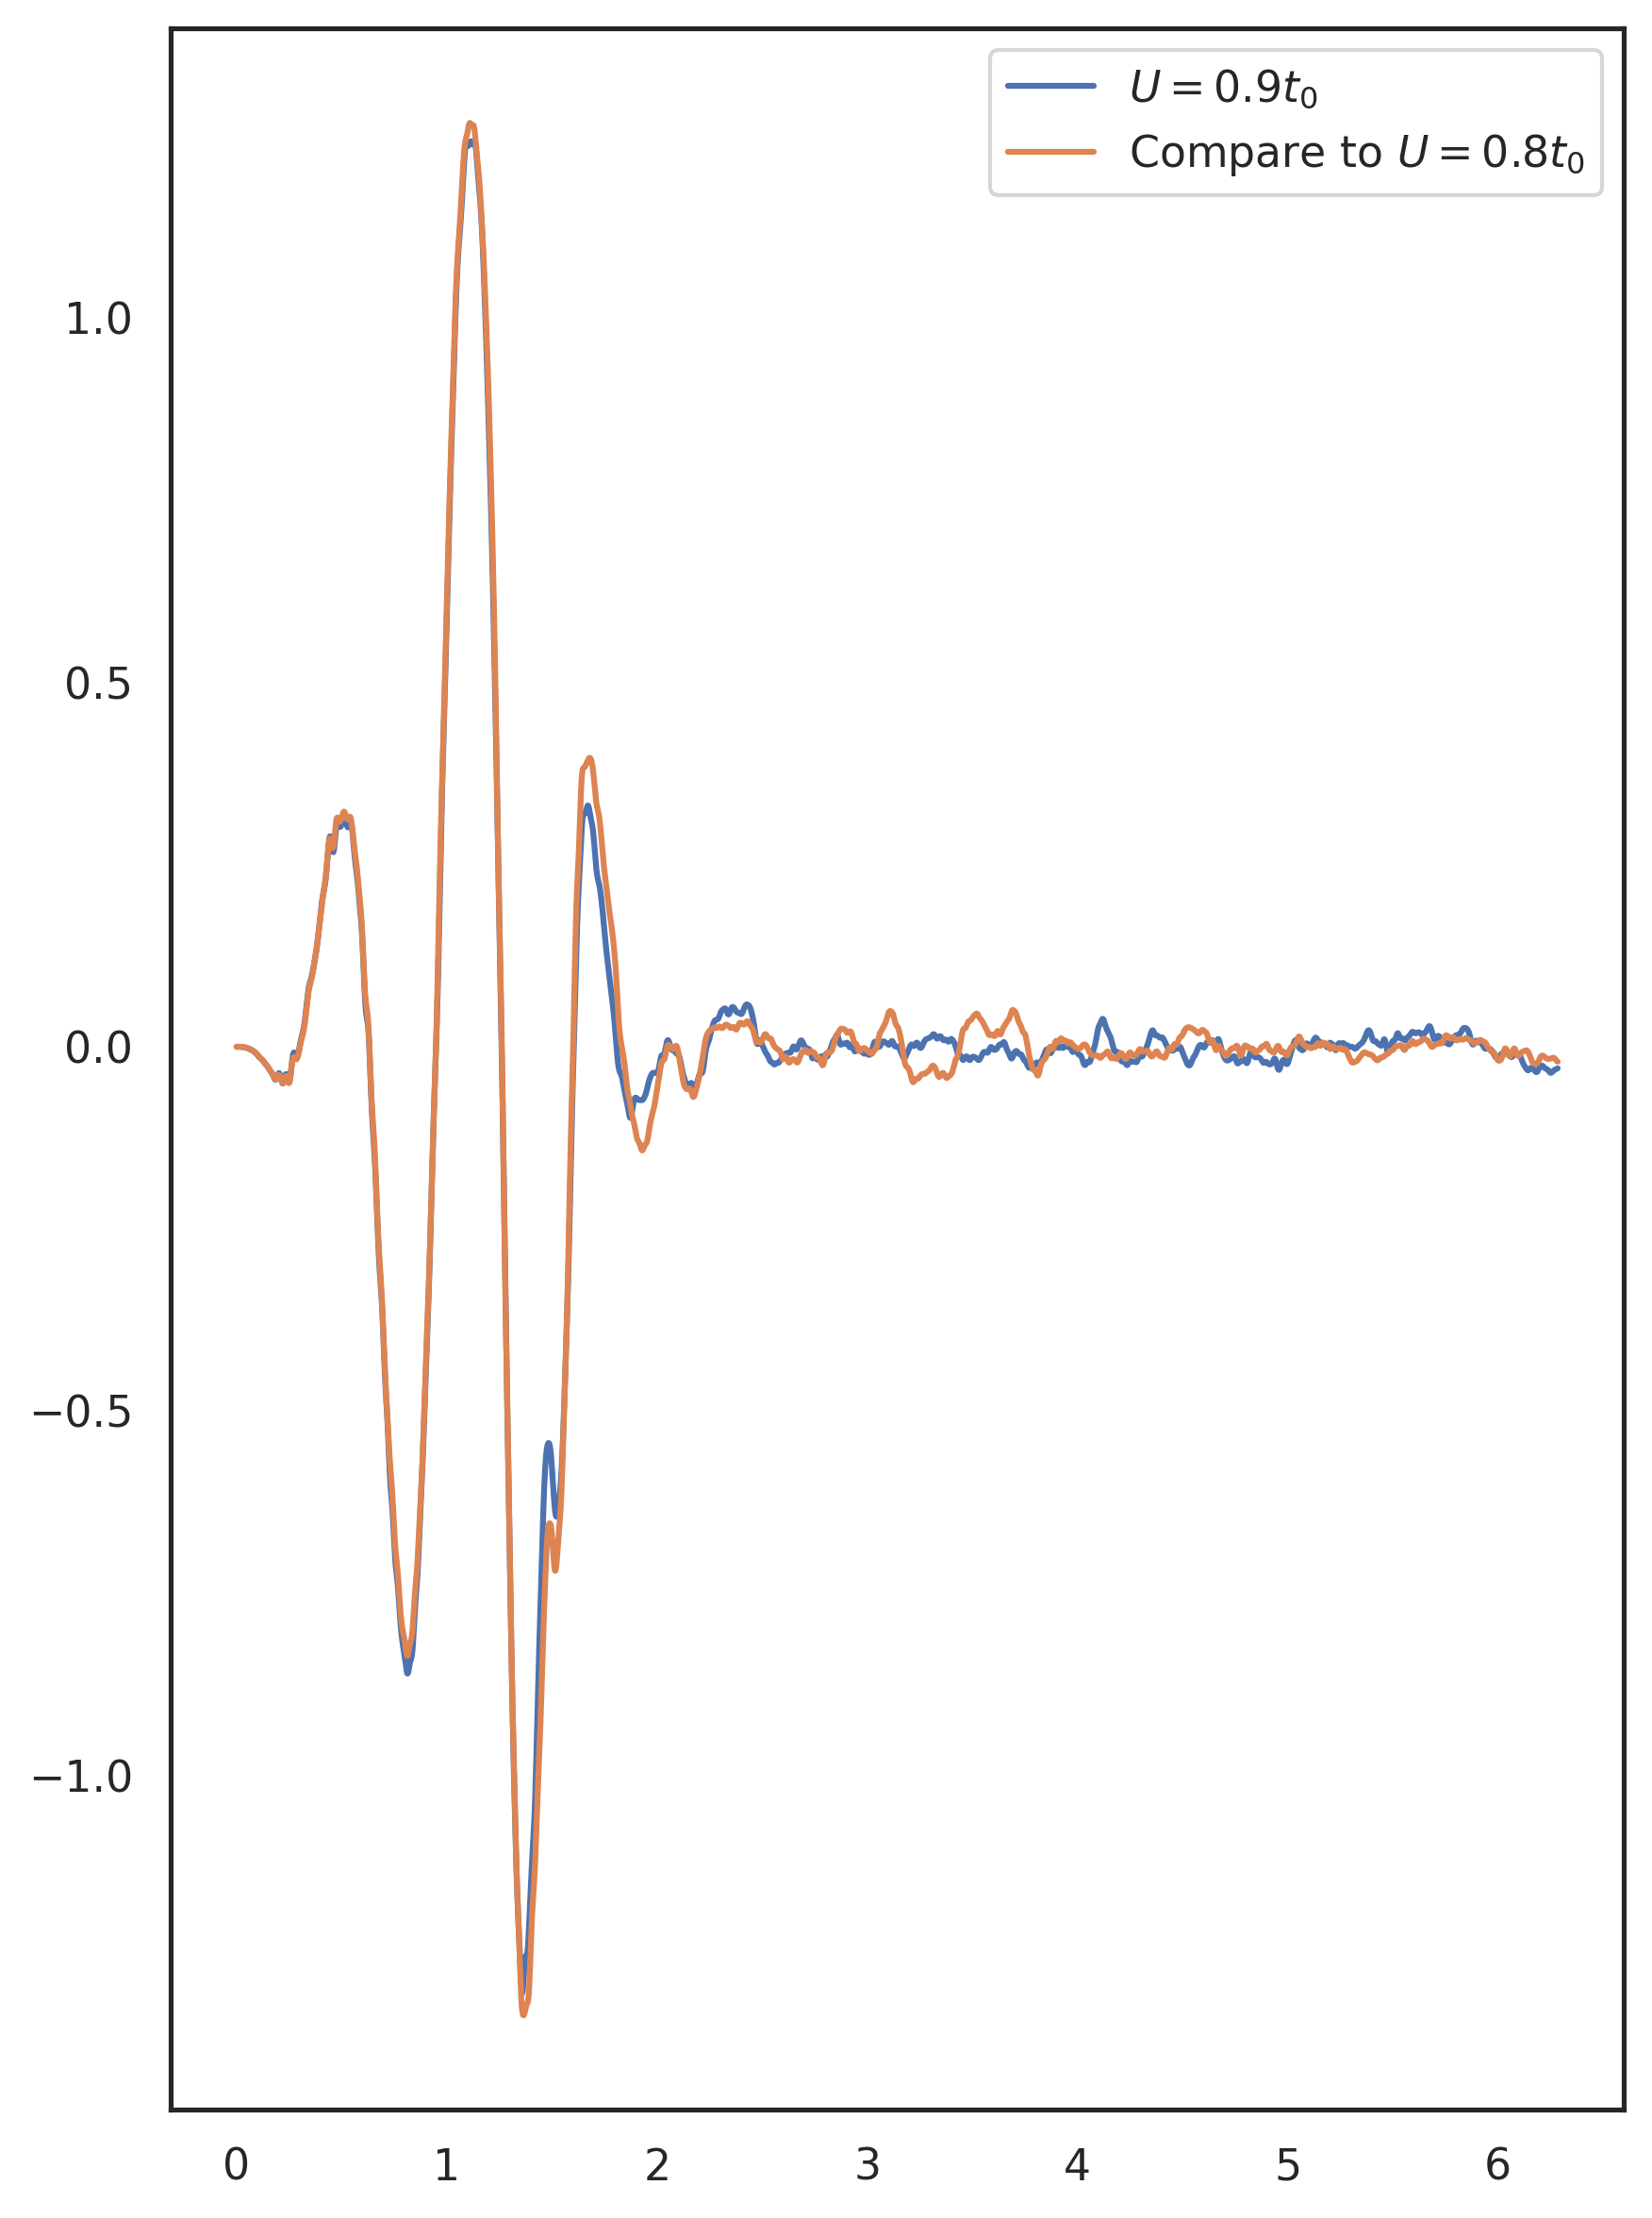

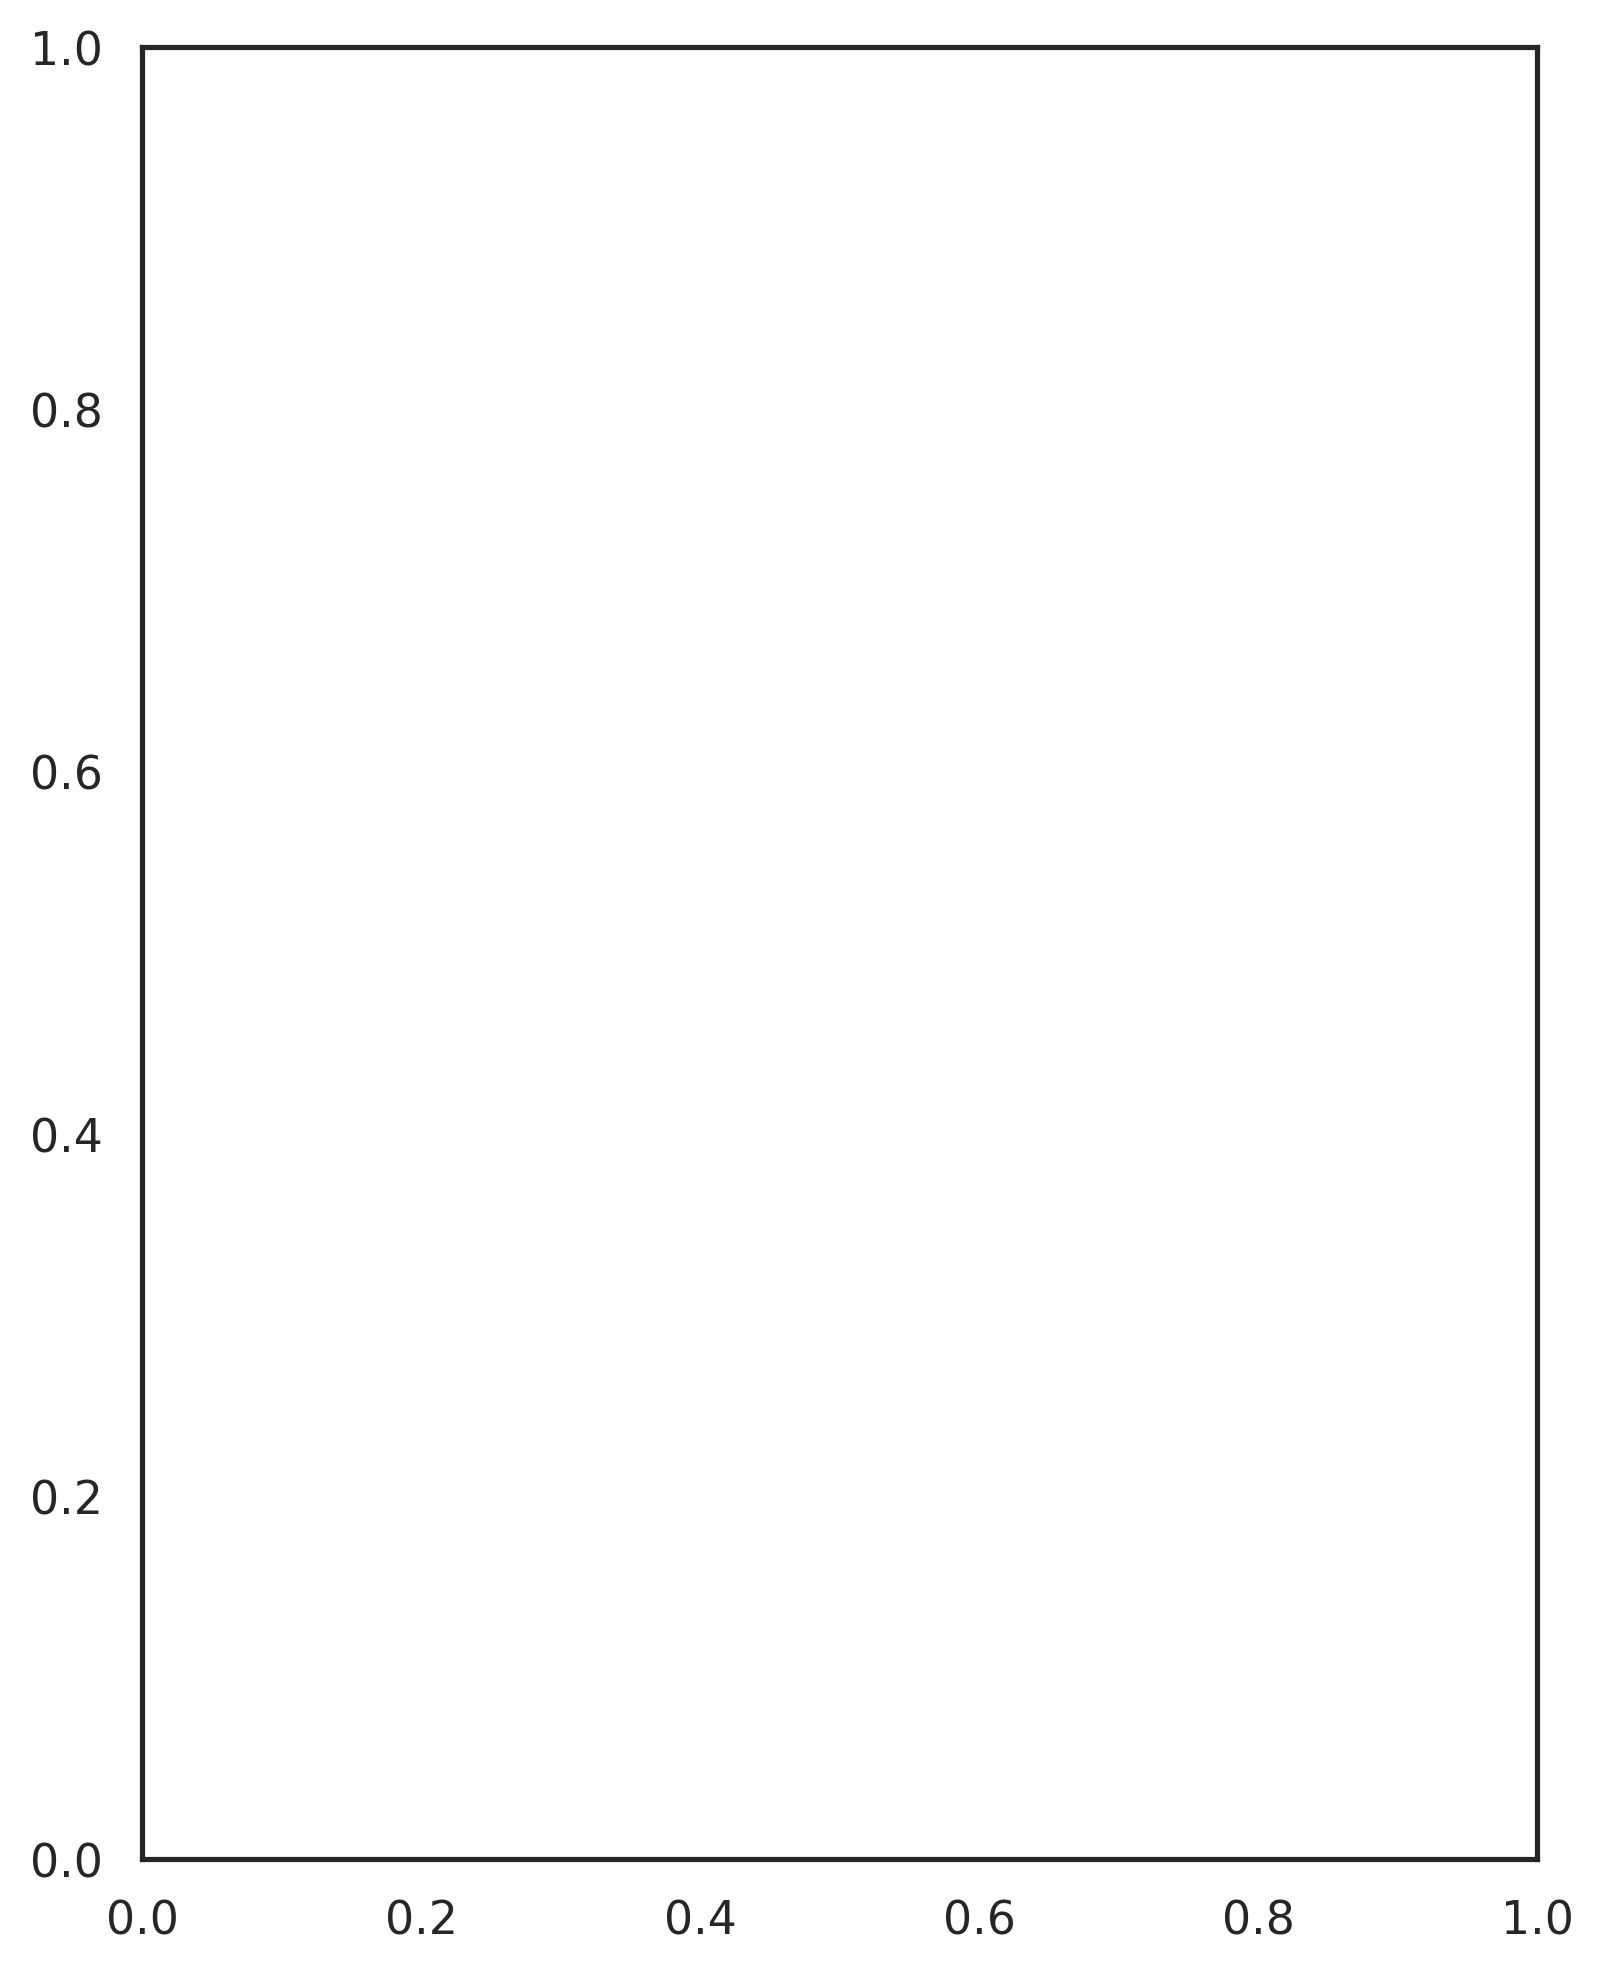

In [171]:
fignum = 0
pitimes = np.linspace(0, 2*np.pi, len(file2['current']))
"""for _ in range(len(data1['amplitude'])):
    plt.figure(num=fignum, figsize=(6,8), dpi=300)
    fignum +=1
    pitimes = np.linspace(0, 2*np.pi, len(data1['current'][_]))
    plt.plot(pitimes, data1['current'][_], label='$U=0.9t_0$')
    plt.plot(pitimes2, file2['current'], label='Compare to $U=0.8t_0$')
    plt.legend()
    plt.tight_layout()
    plt.savefig('./Plots/Looping/Amplitude_{}-CurrentComparison'.format(str(data1['amplitude'][_]).replace('.', ',')))
    if fignum >= 19:
        plt.close('all')
        fignum = 0
        """


"""    plt.figure(num=fignum, figsize=(6,8), dpi=300)
    fignum +=1
    plt.plot(pitimes, data1['diff'][_], label='$\|J_0.9t_0 - J_0.8t_0 \|$ at Amplitude: {}'.format(data1['amplitude']))
    plt.legend()
    plt.tight_layout()
    plt.savefig('./Plots/Looping/Amplitude_{}-NormDifference'.format(str(data1['amplitude'][_]).replace('.', ',')))"""



In [140]:
for a, b, c in product(amps, dels, freqs):
    sweep_params.append([a, b, c])

divisor = int(len(sweep_params) / 20)
iterator = int(len(sweep_params) / divisor)
print(iterator)
print(divisor)

20
50


In [141]:
"""for _ in range(0, divisor):
    print(len(sweep_params[(_ * iterator): ((_ + 1) * iterator)]))"""
print(len(range(0, divisor)))

50


In [63]:
np.argsort(diff[50])
diff[50, 35]

diff[50, 361]

2.4663721489766517